# PROJET 6 : partie 2 - Entrainement et Predictions


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Chargement des données

### Import des librairies

In [2]:
import pandas as pd
import os
import numpy as np
import urllib
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, decomposition,multiclass, ensemble, preprocessing, metrics,linear_model
from sklearn import preprocessing
import mglearn
from mglearn import tools
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

### Chargement de la Pipeline et d'autres données

In [3]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)

X_train = joblib.load(parent_path + "\\pipeline\\X_train.pkl") 
X_test = joblib.load(parent_path + "\\pipeline\\X_test.pkl") 
y_train = joblib.load(parent_path + "\\pipeline\\y_train.pkl") 
y_test = joblib.load(parent_path + "\\pipeline\\y_test.pkl") 

data_train = joblib.load(parent_path + "\\pipeline\\data_train.pkl") 
data_test = joblib.load(parent_path + "\\pipeline\\data_test.pkl")

# dataframes et données
vectorizer = joblib.load(parent_path + "\\pipeline\\vectorizer.pkl")
count_tags_df = joblib.load(parent_path + "\\pipeline\\count_tags_df.pkl")
most_popular_tag = joblib.load(parent_path + "\\pipeline\\most_popular_tag.pkl")
unique_tags_serie = joblib.load(parent_path + "\\pipeline\\unique_tags_serie.pkl")
unique_tags = joblib.load(parent_path + "\\pipeline\\unique_tags.pkl")
selected_tags = joblib.load(parent_path + "\\pipeline\\selected_tags.pkl")

In [4]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(32271, 3849)
(10757, 3849)
(32271, 99)
(10757, 99)


## Fonctions liées à l'entrainement et aux tests

In [5]:
def get_lda_frequent_tags(row, min_frequency, most_frequent_tag):
    """
        Retourne les tags les plus fréqemment associés aux topics LDA
    """
    # Classement des lignes
    sorted_row = row.sort_values(ascending=False)
    
    # Test si au moins un Tag dépasse le seuil de fréquence minimum
    if sorted_row[0] >= min_frequency:
        acceptable_values = sorted_row[sorted_row >= min_frequency].index.values
        if len(acceptable_values) > 5 :
            output = acceptable_values[:5]
        else:
            output = acceptable_values
    # Sinon affichage du Tag le plus fréquent
    else:
        output = [most_frequent_tag]
    
    return output

In [6]:
def mean_local_recall(truth_pred_comparison_df, unique_tags_serie):
    """
    Fonction qui retourne la moyenne du Local_Recall
    """
    ### Moyenne du local_Recall #
    truth_pred_comparison_df['Local_Recall'] = truth_pred_comparison_df.apply(local_recall, axis=1)
    mean_local_recall = truth_pred_comparison_df.Local_Recall.mean()
    print("Recall moyen : %.2f" % mean_local_recall)
    return mean_local_recall
    

In [7]:
def other_scores(truth_pred_comparison_df, unique_tags_serie):
    """
    Fonction qui retourne le F1 Score, Recall et la précision
    """

    # Fractionnement des tags
    y_true_splitted = truth_pred_comparison_df.True_Tags.apply(lambda x: x.split("/"))
    y_pred_splitted = truth_pred_comparison_df.Predicted_Tags.apply(lambda x: x.split("/"))
    
    # Binarisation
    binarizer = preprocessing.MultiLabelBinarizer().fit(unique_tags_serie)

    # Métriques sur samples
    
    f1_score = metrics.f1_score(binarizer.transform(y_true_splitted),
                                binarizer.transform(y_pred_splitted),
                                average='samples')
    

    
    accuracy = metrics.precision_score(binarizer.transform(y_true_splitted),
                                binarizer.transform(y_pred_splitted),
                                average='samples')
    
    print("F1 Score : %.3f" % f1_score)
    # print("Recall : %.3f" % recall)
    print("Précision : %.3f" % accuracy)
    return f1_score, accuracy

In [8]:
def local_recall(row):
    """
    Fonction qui permet de retourner pour une prédiction le rappel ou la sensibilité qui correspond au
    rapport de nombre de documents correctement attribués à la classe i par le nombre de documents appartenant à la classe i.
    
    """
    # On obtient la liste des TAGS
    y_true = row.True_Tags.split("/")
    y_pred = row.Predicted_Tags.split("/")
    
    # Calcul de la difference
    diff = np.setdiff1d(y_true, y_pred)
    len_diff = len(y_true) - len(diff)
    local_recall = len_diff / len(y_true)
    
    # Local recall retourné
    return local_recall

In [9]:
def get_top_probable_tags(row, selected_tags):
    """
    Retourne à partir des probabilités d'une ligne le top 5 des tags associés
    """
    # On classe les probabilités
    probas = row.sort_values(ascending=False)

    # Quel nombre de TAGS est prédit ? On décompte les probas nulles
    n_pred_tags = len(probas[probas > 0])
    # Si on a au moins 5 TAGS
    if n_pred_tags >= 5 :
        # On récupère les tags associés
        out_tags = probas[:5].index.values
    elif n_pred_tags == 0:
        # Sinon on récupère le premier
        out_tags = np.array(selected_tags[0])
    else:
        out_tags = probas[:n_pred_tags].index.values

    # String en sortie avec conversion en liste
    if n_pred_tags > 1:
        out_string = "/".join(out_tags.tolist())
    elif n_pred_tags == 1:
        out_string = out_tags.tolist()[0]
    else:
        out_string = out_tags.tolist()
    
    return out_string

# LDA  - Classification non supervisée

## Phase d'entrainement

In [10]:
X_train_tfidf = X_train
no_topics = 10
# LDA
lda = decomposition.LatentDirichletAllocation(n_components=no_topics, 
                                              max_iter=5, 
                                              learning_method='online', 
                                              learning_offset=50.,
                                              random_state=0)
lda_output = lda.fit_transform(X_train_tfidf)

In [11]:
# Log Likelyhood: valeur élevé = meilleur modèle
print("Log Likelihood: ", lda.score(X_train_tfidf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X_train_tfidf))
# Paramètres du modèle
print(lda.get_params())

Log Likelihood:  -860196.3098949725
Perplexity:  6622.875566629232
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Affichons les probabilités d'appartenir à tel ou tel topic pour chaque mot du dictionnaire

In [12]:
topicnames = ["Topic" + str(i) for i in range(no_topics)]
# Matrice avec mots clés des topics
df_topic_keywords = pd.DataFrame(lda.components_)

# Assigner Colonnes et Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# Affichage
df_topic_keywords.iloc[0:15,0:15]

,ab,abort,aborted,abs,abstraction,ac,accepted,accepting,accepts,acceptverbs,accessed,accesses,accessibility,accessing,accessor
Topic0,0.100018,0.100013,0.100005,0.100088,0.100006,0.100181,0.100009,0.100002,0.100056,0.100006,0.100106,0.100014,6.714738,0.100050,0.100001
Topic1,7.758296,0.331266,0.100020,0.100032,0.100028,8.014425,0.100093,0.100154,4.016082,0.100001,1.384986,0.100011,0.100007,0.100513,0.757126
Topic2,0.100005,0.100007,0.100014,0.100237,0.100005,0.100001,0.100015,0.100021,0.100027,0.100016,0.100080,0.100011,0.100080,4.648931,0.100004
Topic3,0.100020,0.100090,0.100014,0.100000,0.100034,0.100033,0.100011,0.100050,0.100009,0.100000,4.146435,0.100166,0.100217,12.823868,0.100010
Topic4,0.100116,0.100001,0.100004,0.100015,0.100014,0.100057,0.100007,0.100062,0.100014,0.100012,0.100133,0.100010,0.100004,1.604202,0.100015
Topic5,0.100061,15.607464,3.327460,0.100076,7.393059,0.100103,7.530781,5.725198,7.657121,7.917689,10.820015,5.526641,0.100191,8.748901,8.306123
Topic6,0.100047,0.100004,0.100001,0.100039,0.100016,0.100076,0.100005,0.100055,0.100015,0.100002,0.100142,0.100006,0.100091,0.100031,0.100000
Topic7,0.357526,0.100072,0.100014,0.100013,0.100037,0.100149,8.228104,3.369428,2.942229,0.100012,0.100144,0.100043,0.100070,8.286542,0.100016
Topic8,0.100007,0.100097,3.189074,0.100008,0.100007,0.100253,0.100024,0.100089,0.100010,0.100001,0.100040,0.100047,0.100355,0.100909,0.100004
Topic9,4.981142,0.100242,0.100073,9.542179,2.775354,0.100075,9.028708,0.100095,4.582609,0.100006,12.720371,6.257451,0.100030,15.150634,0.100147


On constate que le premier topic récupère les mots très généraux ou sans consistance réel.

In [13]:
# Appliquons des noms aux indexes
docnames = ["Body Title N°" + str(i) for i in range(X_train.shape[0])]

# # Construction pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 3), columns=topicnames, index=docnames)

# topic dominant pour chaque document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
max_proba_topic = np.max(lda_output, axis=1)
df_document_topic['max_proba_topic'] = max_proba_topic.round(3)
df_document_topic['dominant_topic'] = dominant_topic

# Styles
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Application du Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,max_proba_topic,dominant_topic
Body Title N°0,0.028,0.028,0.192,0.028,0.028,0.215,0.028,0.028,0.028,0.397,0.397,9
Body Title N°1,0.02,0.02,0.02,0.036,0.02,0.02,0.105,0.715,0.02,0.02,0.715,7
Body Title N°2,0.023,0.023,0.023,0.074,0.023,0.023,0.023,0.545,0.023,0.216,0.545,7
Body Title N°3,0.032,0.032,0.032,0.032,0.032,0.032,0.22,0.526,0.032,0.032,0.526,7
Body Title N°4,0.022,0.486,0.022,0.022,0.022,0.022,0.022,0.335,0.022,0.022,0.486,1
Body Title N°5,0.024,0.345,0.024,0.316,0.024,0.174,0.024,0.024,0.024,0.024,0.345,1
Body Title N°6,0.022,0.022,0.022,0.693,0.022,0.022,0.022,0.022,0.022,0.133,0.693,3
Body Title N°7,0.708,0.032,0.032,0.032,0.032,0.032,0.032,0.032,0.032,0.032,0.708,0
Body Title N°8,0.019,0.257,0.054,0.019,0.019,0.019,0.019,0.557,0.019,0.019,0.557,7
Body Title N°9,0.029,0.029,0.029,0.029,0.029,0.029,0.029,0.74,0.029,0.029,0.74,7


C:\Users\Windows 10\Anaconda3\envs\envapp3\lib\site-packages\matplotlib\cbook\__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
C:\Users\Windows 10\Anaconda3\envs\envapp3\lib\site-packages\matplotlib\cbook\__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


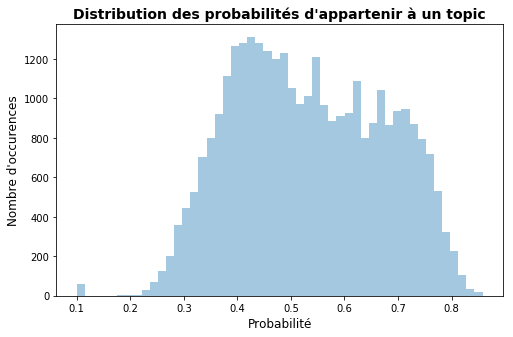

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
max_proba_topic = np.max(lda_output, axis=1)
sns.distplot(df_document_topic['max_proba_topic'], kde=False)
ax.set_xlabel("Probabilité", fontsize=12)
ax.set_ylabel("Nombre d'occurences", fontsize=12)
ax.set_title("Distribution des probabilités d'appartenir à un topic", fontsize=14, weight="bold");

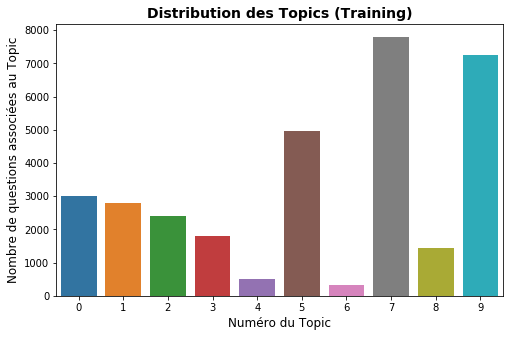

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(df_document_topic["dominant_topic"])
ax.set_xlabel("Numéro du Topic", fontsize=12)
ax.set_ylabel("Nombre de questions associées au Topic", fontsize=12)
ax.set_title("Distribution des Topics (Training)", fontsize=14, weight="bold");

In [16]:
topics, counts = np.unique(df_document_topic['max_proba_topic'], return_counts=True)
main_topic = topics[np.argsort(-counts)][0]

In [17]:
#  Montre le top des mots par Topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

Visualisons par exemples sur plus de 10 mots

In [18]:
df_topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=15)
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,div,javascript,html,jquery,css,width,images,px,img,td,var,font,iphone,span,window
Topic 1,int,excel,char,std,byte,regex,void,const,console,str,myclass,characters,vector,pointer,buffer
Topic 2,wpf,controls,asp,window,textbox,vb,grid,binding,sender,events,forms,ui,dialog,gridview,winforms
Topic 3,windows,server,app,iis,sharepoint,asp,folder,iphone,flex,config,directory,services,upload,installed,vista
Topic 4,java,apache,iframe,download,tomcat,swf,mod,audio,cons,println,outlook,servlet,pros,actionscript,qt
Topic 5,objects,int,null,java,classes,static,methods,interface,nhibernate,void,properties,values,email,hibernate,generic
Topic 6,silverlight,python,delphi,dictionary,numbers,ip,zip,batch,algorithm,obj,def,append,digits,characters,spaces
Topic 7,xml,php,html,com,asp,url,mvc,eclipse,python,java,javascript,svn,ajax,server,rails
Topic 8,windows,dll,debug,linux,os,exe,debugger,mac,compiler,cpu,debugging,java,ruby,threads,unix
Topic 9,sql,database,server,query,mysql,linq,tables,db,stored,rows,values,columns,users,oracle,delete


Cela nous permet de voir les thèmes qui ressortent de façon assez claire.

Cherchons les principaux tags associés pour chacun des topics

In [19]:
# Intialisation de Matrice de dimension
tags_topics = np.zeros((no_topics, len(unique_tags)))

In [20]:
test_tags_topics_df = pd.DataFrame(tags_topics, columns=unique_tags, dtype='int64')
for i, topic in enumerate(df_document_topic["dominant_topic"]):
    for tag in data_train["New_tags"].iloc[i].split("/"):
        test_tags_topics_df.loc[topic, tag] += 1


In [21]:
min_frequency_tag = 0
main_tags_by_topics = test_tags_topics_df.apply(get_lda_frequent_tags, args=(min_frequency_tag,
                                                                                most_popular_tag), axis=1)

In [22]:
main_tags_by_topics_df = pd.DataFrame()
main_tags_by_topics_df['LDA Topic'] = main_tags_by_topics.index.values
main_tags_by_topics_df['Tags associés'] = main_tags_by_topics.values
word_topics = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10
                         )
word_topics.index = main_tags_by_topics_df.index.values

# On sélectionne les 5 premiers mots de chaque topic
word_topics_grouped = word_topics.apply(lambda x: '/'.join(x.dropna().values.tolist()[0:5]), axis=1)
word_topics_df = pd.DataFrame(word_topics_grouped)
word_topics_df.columns=["Topics_group"]

pd.concat([main_tags_by_topics_df, word_topics_df],axis=1)

,LDA Topic,Tags associés,Topics_group
0,0,"[javascript, jquery, css, html, iphone]",div/javascript/html/jquery/css
1,1,"[c++, c#, c, .net, java]",int/excel/char/std/byte
2,2,"[c#, asp.net, wpf, .net, winforms]",wpf/controls/asp/window/textbox
3,3,"[c#, .net, asp.net, windows, sharepoint]",windows/server/app/iis/sharepoint
4,4,"[java, c#, apache, flash, .net]",java/apache/iframe/download/tomcat
5,5,"[c#, java, .net, c++, asp.net]",objects/int/null/java/classes
6,6,"[python, c#, .net, algorithm, silverlight]",silverlight/python/delphi/dictionary/numbers
7,7,"[java, c#, php, javascript, .net]",xml/php/html/com/asp
8,8,"[.net, c++, c#, java, windows]",windows/dll/debug/linux/os
9,9,"[c#, sql-server, sql, .net, mysql]",sql/database/server/query/mysql


## Phase de prédiction -  LDA

In [23]:
lda_output_test = lda.transform(X_test)

In [24]:
topicnames = ["Topic" + str(i) for i in range(no_topics)]
# Nom des indexes
docnames_test = ["Body Title N°" + str(i) for i in range(X_test.shape[0])]

# Construction de pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(lda_output_test, 3), columns=topicnames, index=docnames_test)

# Topic dominant pour chaque texte
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)
max_proba_topic_test = np.max(lda_output_test, axis=1)
df_document_topic_test['max_proba_topic_test'] = max_proba_topic_test.round(3)
df_document_topic_test['dominant_topic_test'] = dominant_topic_test

# Mise en couleur
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Application de la mise en couleur
df_document_topics_test = df_document_topic_test.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics_test

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,max_proba_topic_test,dominant_topic_test
Body Title N°0,0.031,0.337,0.031,0.031,0.031,0.417,0.031,0.031,0.031,0.031,0.417,5
Body Title N°1,0.248,0.035,0.475,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.475,2
Body Title N°2,0.019,0.077,0.019,0.019,0.042,0.043,0.055,0.689,0.019,0.019,0.689,7
Body Title N°3,0.025,0.025,0.127,0.025,0.025,0.21,0.025,0.487,0.025,0.025,0.487,7
Body Title N°4,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.743,0.02,0.093,0.743,7
Body Title N°5,0.023,0.023,0.023,0.023,0.113,0.023,0.023,0.023,0.023,0.703,0.703,9
Body Title N°6,0.232,0.459,0.021,0.021,0.021,0.021,0.021,0.125,0.021,0.057,0.459,1
Body Title N°7,0.017,0.04,0.133,0.017,0.041,0.112,0.042,0.564,0.017,0.017,0.564,7
Body Title N°8,0.028,0.447,0.028,0.028,0.028,0.028,0.028,0.028,0.028,0.33,0.447,1
Body Title N°9,0.662,0.027,0.027,0.027,0.027,0.027,0.027,0.118,0.027,0.027,0.662,0


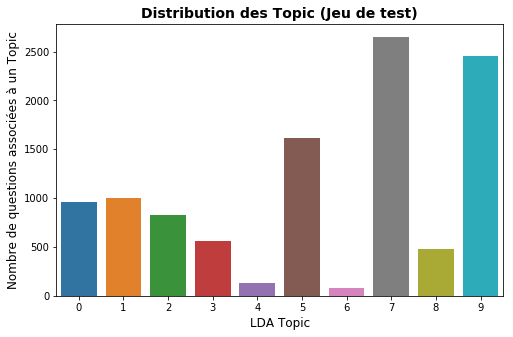

In [25]:
# Distribution des Topics (Training)
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(df_document_topic_test["dominant_topic_test"])
ax.set_xlabel("LDA Topic", fontsize=12)
ax.set_ylabel("Nombre de questions associées à un Topic", fontsize=12)
ax.set_title("Distribution des Topic (Jeu de test)", fontsize=14, weight="bold");

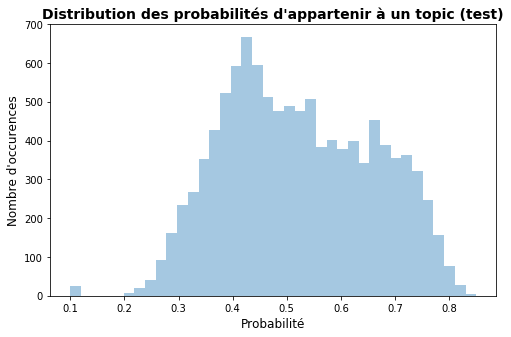

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(df_document_topic_test['max_proba_topic_test'], kde=False)
ax.set_xlabel("Probabilité", fontsize=12)
ax.set_ylabel("Nombre d'occurences", fontsize=12)
ax.set_title("Distribution des probabilités d'appartenir à un topic (test)", fontsize=14, weight="bold");

Cherchons désormais à afficher à la fois nos prédictions, les tags associés et les différents scores à chaque document.

In [27]:
y_pred_lda = pd.DataFrame(dominant_topic_test, index=y_test.index, columns=['topics'])
y_pred_topic = y_pred_lda.copy()

y_pred_lda['pred_tags'] = y_pred_lda.topics.apply(lambda x: main_tags_by_topics[x])
y_pred_topic['word_topics_predicted'] = y_pred_lda.topics.apply(lambda x: word_topics_grouped[x])

y_true_tags = pd.DataFrame(data_test["New_tags"].values, index=y_test.index, columns=['true_tags'])

y_pred_lda = y_pred_lda.drop(labels=['topics'], axis=1)
y_pred_topic = y_pred_topic.drop(labels=['topics'], axis=1)

lda_comparison_df= pd.concat((y_pred_lda, y_true_tags), axis=1)
lda_comparison_df_topic= pd.concat((y_pred_topic, y_true_tags), axis=1)
lda_comparison_df.columns = ['Predicted_Tags', 'True_Tags']
lda_comparison_df_topic.columns = ["Predicted_Tags", 'True_Tags']

#  '/' join sur les tags prédits
lda_comparison_df['Predicted_Tags'] = lda_comparison_df['Predicted_Tags'].apply(lambda x: "/".join(x))
# lda_comparison_df_topic['Predicted_Tags'] = lda_comparison_df_topic['Predicted_Tags'].apply(lambda x: "/".join(x))

lda_comparison_df['Local_Recall'] = lda_comparison_df.apply(local_recall, axis=1)
lda_comparison_df_topic['Local_Recall'] = lda_comparison_df_topic.apply(local_recall, axis=1)

In [28]:
# Affichage première méthode de prédiction
display(lda_comparison_df.sample(20))
mean_local_recall(lda_comparison_df, unique_tags_serie)
other_scores(lda_comparison_df, unique_tags_serie)

,Predicted_Tags,True_Tags,Local_Recall
4761,javascript/jquery/css/html/iphone,.net,0.000000
10206,c#/sql-server/sql/.net/mysql,.net,1.000000
5085,.net/c++/c#/java/windows,visual-studio-2008/debugging,0.000000
4499,c#/asp.net/wpf/.net/winforms,linux,0.000000
10475,c#/java/.net/c++/asp.net,hibernate,0.000000
9751,c#/sql-server/sql/.net/mysql,javascript/jquery/css,0.000000
6237,c#/asp.net/wpf/.net/winforms,objective-c/iphone/cocoa-touch,0.000000
904,java/c#/php/javascript/.net,ruby-on-rails/ruby,0.000000
1888,c#/java/.net/c++/asp.net,java,1.000000
2194,c#/java/.net/c++/asp.net,c#,1.000000


Recall moyen : 0.39
F1 Score : 0.187
Précision : 0.129


(0.18697149585873207, 0.12938551640792045)

In [29]:
# Affichage deuxième méthode de prédiction
display(lda_comparison_df_topic.sample(20))
mean_local_recall(lda_comparison_df_topic, unique_tags_serie)
other_scores(lda_comparison_df_topic, unique_tags_serie)

,Predicted_Tags,True_Tags,Local_Recall
8539,xml/php/html/com/asp,css/user-interface,0.0
2294,objects/int/null/java/classes,java,1.0
5806,xml/php/html/com/asp,ruby-on-rails,0.0
9756,sql/database/server/query/mysql,sql-server/visual-studio-2008,0.0
8907,sql/database/server/query/mysql,php/javascript,0.0
4939,xml/php/html/com/asp,unix,0.0
5624,wpf/controls/asp/window/textbox,.net/vb.net,0.0
6171,wpf/controls/asp/window/textbox,asp.net,0.0
208,sql/database/server/query/mysql,c#/asp.net,0.0
6387,int/excel/char/std/byte,php,0.0


Recall moyen : 0.15


C:\Users\Windows 10\Anaconda3\envs\envapp3\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['app', 'asp', 'classes', 'debug', 'div', 'objects', 'os', 'query', 'server'] will be ignored
  .format(sorted(unknown, key=str)))
C:\Users\Windows 10\Anaconda3\envs\envapp3\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['app', 'asp', 'classes', 'debug', 'div', 'objects', 'os', 'query', 'server'] will be ignored
  .format(sorted(unknown, key=str)))


F1 Score : 0.091
Précision : 0.070


(0.09073154284179664, 0.0698568374081993)

Affichage des topics ainsi que les mots clés de ceux-ci.

In [30]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X_test, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
9       82.446114 -75.692902       1        1  19.589491
7       95.341888  55.061302       2        1  19.477065
5      120.691437 -13.451857       3        1  13.978069
1      -48.630131 -62.766533       4        1   9.114115
0      -35.736584  67.987938       5        1   8.656121
2       30.014048  63.667496       6        1   8.117956
3       -6.681056  -0.888438       7        1   6.848037
8       16.697300 -71.366776       8        1   6.225018
4       53.392010  -6.812765       9        1   4.290653
6      -73.981071   5.746032      10        1   3.703475, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
1811  Default  190.000000          java  190.000000  30.0000  30.0000
2655  Default  124.000000        python  124.000000  29.0000  29.0000
978   Default   92.000000           div   92.000000  28.0000  28.0000
3754  Default  164.000000       windows  164.000000  27.0000  27.0000
3175  Default  163.000000           sql  163.000000  26.0000  26.0000
1719  Default  135.000000           int  135.000000  25.0000  25.0000
3085  Default   62.000000   silverlight   62.000000  24.0000  24.0000
1814  Default  125.000000    javascript  125.000000  23.0000  23.0000
1565  Default  127.000000          html  127.000000  22.0000  22.0000
1839  Default   85.000000        jquery   85.000000  21.0000  21.0000
191   Default  166.000000           asp  166.000000  20.0000  20.0000
3036  Default  210.000000        server  210.000000  19.0000  19.0000
3785  Default   60.000000           wpf   60.000000  18.0000  18.0000
745   Default   63.000000           css   63.000000  17.0000  17.0000
782   Default  144.000000      database  144.000000  16.0000  16.0000
983   Default   69.000000           dll   69.000000  15.0000  15.0000
684   Default   60.000000      controls   60.000000  14.0000  14.0000
876   Default   48.000000        delphi   48.000000  13.0000  13.0000
2283  Default   44.000000       numbers   44.000000  12.0000  12.0000
931   Default   39.000000    dictionary   39.000000  11.0000  11.0000
3753  Default   87.000000        window   87.000000  10.0000  10.0000
1608  Default   45.000000           iis   45.000000   9.0000   9.0000
1772  Default   64.000000        iphone   64.000000   8.0000   8.0000
3059  Default   41.000000    sharepoint   41.000000   7.0000   7.0000
3395  Default   43.000000       textbox   43.000000   6.0000   6.0000
833   Default   48.000000         debug   48.000000   5.0000   5.0000
2663  Default   94.000000         query   94.000000   4.0000   4.0000
134   Default  128.000000           app  128.000000   3.0000   3.0000
130   Default   40.000000        apache   40.000000   2.0000   2.0000
1311  Default   51.000000        folder   51.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
2235  Topic10    5.644208       newline    5.955131   3.2423  -5.3619
3025  Topic10    5.550150     sequences    5.860929   3.2414  -5.3787
788   Topic10    5.642465  datacontract    5.959094   3.2413  -5.3623
2108  Topic10    5.439603         mingw    5.750466   3.2403  -5.3989
3172  Topic10    5.118862       sprintf    5.429703   3.2369  -5.4596
3610  Topic10    5.082260           usa    5.393122   3.2365  -5.4668
873   Topic10    5.045394     delimiter    5.356144   3.2361  -5.4741
2366  Topic10    4.990998  outputstream    5.301886   3.2355  -5.4849
174   Topic10    4.954527    arithmetic    5.265340   3.2351  -5.4923
1873  Topic10    4.922722        kwargs    5.233666   3.2346  -5.4987
3847  Topic10   20.858905           zip   24.273188   3.1443  -4.0548
3085  Topic10   49.741061   silverlight   62.270770   3.0712  -3.1857
931   Topic10   31.336590    dictionary   39.224340   3.0714  -3.6478
876   Topic10   35.123776        delphi   48.224253  

# Classification Supervisée MULTI LABEL

## Régression logistique

In [31]:
import shutil
import glob
import os
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
reg_log_path = parent_path + '\\classifiers\\logistical_regression'

if os.path.exists(reg_log_path):
    shutil.rmtree(reg_log_path)
os.mkdir(reg_log_path)

classifiers = []
count=1
for category in selected_tags:
    print("{}/{} - Entrainement sur le Tag: '{}' ...".format(count, len(selected_tags),category))
# Sélection du classifieur
    clf = linear_model.LogisticRegression(random_state=0)
    clf = clf.fit(X_train, y_train[category])
    joblib.dump(clf, reg_log_path + "\\logreg_"+category + ".pkl") # On sauvegarde notre encodage pour une utilisation ultérieure
    classifiers.append(clf)
    count=count+1


1/99 - Entrainement sur le Tag: 'c#' ...
2/99 - Entrainement sur le Tag: '.net' ...
3/99 - Entrainement sur le Tag: 'java' ...
4/99 - Entrainement sur le Tag: 'asp.net' ...
5/99 - Entrainement sur le Tag: 'javascript' ...
6/99 - Entrainement sur le Tag: 'c++' ...
7/99 - Entrainement sur le Tag: 'php' ...
8/99 - Entrainement sur le Tag: 'python' ...
9/99 - Entrainement sur le Tag: 'sql' ...
10/99 - Entrainement sur le Tag: 'sql-server' ...
11/99 - Entrainement sur le Tag: 'jquery' ...
12/99 - Entrainement sur le Tag: 'html' ...
13/99 - Entrainement sur le Tag: 'iphone' ...
14/99 - Entrainement sur le Tag: 'mysql' ...
15/99 - Entrainement sur le Tag: 'windows' ...
16/99 - Entrainement sur le Tag: 'asp.net-mvc' ...
17/99 - Entrainement sur le Tag: 'c' ...
18/99 - Entrainement sur le Tag: 'wpf' ...
19/99 - Entrainement sur le Tag: 'css' ...
20/99 - Entrainement sur le Tag: 'ruby-on-rails' ...
21/99 - Entrainement sur le Tag: 'visual-studio' ...
22/99 - Entrainement sur le Tag: 'database' .

On calcule les prédictions de probabilités pour le jeu d'entrainement

In [32]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...jeu d'entrainement")

train_predictions = []
count = 1
zero_array = np.zeros((X_train.shape[0]))
for classifier in classifiers:
#     print("trclassifieur {} / {}".format(count, len(classifiers)))
    prediction = classifier.predict_proba(X_train)

    if prediction.shape[1] == 2:
        train_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        train_predictions.append(zero_array)
    count += 1
print("Traitement terminé !")

Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...jeu d'entrainement
Traitement terminé !


### Optimisation du seuil

Nous décions d'introduire un seuil. Pour éviter d’obtenir des prédictions forcées, nous avons introduit un seuil en dessous duquel les probabilités prédites seront jugées trop faibles pour donner un résultat concluant. Comment déterminer le seuil ?
Nous cherchons sa valeur à partir des données d'entrainement

In [33]:
thresh_list = np.linspace(0, 1, 20)
local_recall_list = []
f1_score_list = []
accuracy_list = []
count=1
for threshold in thresh_list:
    print(count)
    # Convertion en Dataframe
    train_predictions_df = pd.DataFrame(np.array(train_predictions).T, columns=y_train.columns)
    # threshold
    trusted_threshold = threshold
    # Condition sur treshold
    train_predictions_df_thresh = train_predictions_df.copy()
    train_predictions_df_thresh[train_predictions_df_thresh < trusted_threshold] = 0

    # On récupère les nouveaux tags dans une dataframe
    y_train_new_tags = pd.DataFrame(data_train["New_tags"].values, columns=["True_Tags"])
    
    # Classement des tags du plus au moins probable
    y_pred_train = train_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)
    y_pred_train.index = y_train_new_tags.index
    
    # Concatenation
    comparison_df_train = pd.concat((y_pred_train, y_train_new_tags), axis=1)
    comparison_df_train.columns = ['Predicted_Tags', 'True_Tags']
    # Calcul des scores
    temp_f1_score, accuracy = other_scores(comparison_df_train, unique_tags_serie)
    temp_local_recall = mean_local_recall(comparison_df_train, unique_tags_serie)
    
    # Remplissage des listes
    local_recall_list.append(temp_local_recall)
    accuracy_list.append(accuracy)
    f1_score_list.append(temp_f1_score)
    count+=1

1
F1 Score : 0.423
Précision : 0.293
Recall moyen : 0.89
2
F1 Score : 0.518
Précision : 0.403
Recall moyen : 0.86
3
F1 Score : 0.602
Précision : 0.547
Recall moyen : 0.77
4
F1 Score : 0.616
Précision : 0.615
Recall moyen : 0.70
5
F1 Score : 0.606
Précision : 0.642
Recall moyen : 0.64
6
F1 Score : 0.583
Précision : 0.643
Recall moyen : 0.59
7
F1 Score : 0.557
Précision : 0.633
Recall moyen : 0.55
8
F1 Score : 0.533
Précision : 0.619
Recall moyen : 0.51
9
F1 Score : 0.507
Précision : 0.600
Recall moyen : 0.48
10
F1 Score : 0.482
Précision : 0.580
Recall moyen : 0.45
11
F1 Score : 0.458
Précision : 0.557
Recall moyen : 0.42
12
F1 Score : 0.434
Précision : 0.534
Recall moyen : 0.40
13
F1 Score : 0.411
Précision : 0.510
Recall moyen : 0.37
14
F1 Score : 0.387
Précision : 0.485
Recall moyen : 0.35
15
F1 Score : 0.363
Précision : 0.459
Recall moyen : 0.32
16
F1 Score : 0.337
Précision : 0.430
Recall moyen : 0.30
17
F1 Score : 0.309
Précision : 0.398
Recall moyen : 0.27
18
F1 Score : 0.276
Pré

#### Nous cherchons à maximiser le F1_score

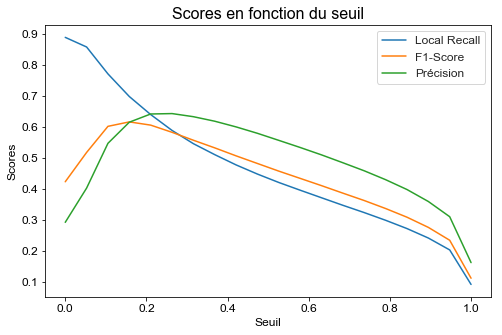

In [34]:
# Représentation des métriques (logistical Regression)
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
plt.plot(thresh_list, local_recall_list, label="Local Recall")
plt.plot(thresh_list, f1_score_list, label="F1-Score")
plt.plot(thresh_list, accuracy_list, label="Précision")
ax.set_title("Scores en fonction du seuil", fontsize=16)
ax.set_xlabel("Seuil", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

In [35]:
print("F1-Score le plus élevé (Régr. Log.) : {}".format(f1_score_list[np.argmax(f1_score_list)]))
print( "Treshold retenu (Régression logistique : {}".format(thresh_list[np.argmax(f1_score_list)]))
print("Local Recall moyen associée : {}".format(local_recall_list[np.argmax(f1_score_list)]))
print("Précision associée : {}".format(accuracy_list[np.argmax(f1_score_list)]))


F1-Score le plus élevé (Régr. Log.) : 0.6164082155436622
Treshold retenu (Régression logistique : 0.15789473684210525
Local Recall moyen associée : 0.6982058194663967
Précision associée : 0.6154571183622033


On calcule les prédictions de probabilités pour le jeu de test

In [36]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...jeu de test")

test_predictions = []
count = 1
zero_array = np.zeros((X_test.shape[0]))
for classifier in classifiers:
#     print("trclassifieur {} / {}".format(count, len(classifiers)))
    prediction = classifier.predict_proba(X_test)

    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    count += 1
print("Traitement terminé !")

Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...jeu de test
Traitement terminé !


On utilise désormais le seuil que l'on vient de déterminer sur notre jeu de test.

In [37]:
# On convertit en pd.dataframe
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test.columns)
# threshold
trusted_threshold = thresh_list[np.argmax(f1_score_list)]
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

In [38]:
# Construction des tags prédites à partir de classifieurs,
# si il y en a plus de 5 nous conservons les 5 premiers avec la probabilité la plus forte
y_pred_ml = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)

# conversion en pd.dataframe
y_pred_ml = pd.DataFrame(y_pred_ml,columns=['Predicted_Tags'])

# On récupère les nouveaux tags dans une dataframe
y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])

# On construit un tableau pour comparer tags prédits et nouveaux tags
multilabel_comparison_df = pd.concat([y_test_new_tags, y_pred_ml], axis=1)

# On applique la fonction qui nous donne nombre de mots-clés justes parmi N mots-clés prédits
multilabel_comparison_df['Local_Recall'] = multilabel_comparison_df.apply(local_recall, axis=1)

# Affichages
display(multilabel_comparison_df.sample(20))
display(mean_local_recall(multilabel_comparison_df, unique_tags_serie))
display(other_scores(multilabel_comparison_df, unique_tags_serie))



,True_Tags,Predicted_Tags,Local_Recall
10279,c#,.net/c#/asp.net,1.000000
10724,delphi,c#,0.000000
4638,asp.net-mvc,asp.net-mvc/asp.net/c#,1.000000
1744,file,c#/macos,0.000000
4702,wcf,web-services/wcf/.net,1.000000
5552,database-design,.net,0.000000
3205,flex/actionscript-3,flash/actionscript-3,0.500000
2399,c++/c,c++/c/macos,1.000000
10433,apache,apache,1.000000
2239,java,java,1.000000


Recall moyen : 0.62


0.6187567785318083

F1 Score : 0.546
Précision : 0.553


(0.5456514842310138, 0.5526292956524433)

#### Courbes ROC

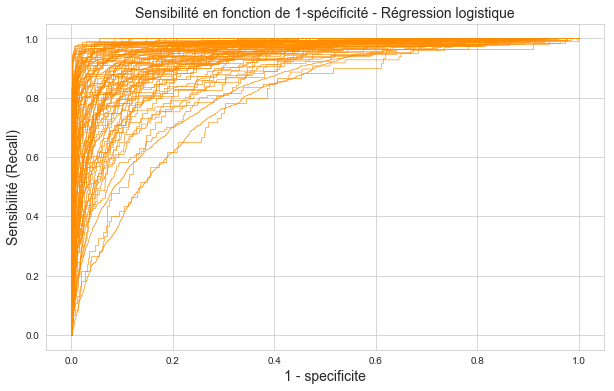

'Moyenne AUC : 0.9499769554356132'

In [39]:
from sklearn.metrics import roc_curve, auc
plt.subplots(figsize=(10,6))
auc_list = []
for indice in range(len(selected_tags)):
    tag_to_classify = y_test.columns[indice]
    fpr, tpr, _ = metrics.roc_curve(y_test[tag_to_classify], test_predictions_df[tag_to_classify])
    auc = metrics.roc_auc_score(y_test[tag_to_classify],  test_predictions_df[tag_to_classify])

    plt.plot(fpr,tpr,label=tag_to_classify+", auc="+str(auc),color='darkorange', lw=0.6)
    auc_list.append(auc)
plt.title('Sensibilité en fonction de 1-spécificité - Régression logistique', fontsize=14)
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilité (Recall)', fontsize=14)
plt.show()

auc_df = pd.DataFrame(auc_list)
auc_df.index = selected_tags
auc_df.columns=["Score Auc"]
# display(auc_df.head(15))
display("Moyenne AUC : {}".format((auc_df["Score Auc"].mean())))

# plt.subplots(figsize=(6,4))
# plt.scatter(range(len(temp)), temp["Score Auc"])

## Naive Bayes

In [40]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
nb_path = parent_path + '\\classifiers\\naive_bayes'

if os.path.exists(nb_path):
    shutil.rmtree(nb_path)
os.mkdir(nb_path)

classifiers = []
count=1
for category in selected_tags:
    print("{}/{} - Entrainement sur le Tag: '{}' ...".format(count, len(selected_tags),category))
# Sélection du classifieur
    clf = MultinomialNB(fit_prior=True, class_prior=None)
    clf= clf.fit(X_train, y_train[category])
    joblib.dump(clf, nb_path + "\\nb_"+category + ".pkl") # On sauvegarde notre encodage pour une utilisation ultérieure
    classifiers.append(clf)
    count=count+1


1/99 - Entrainement sur le Tag: 'c#' ...
2/99 - Entrainement sur le Tag: '.net' ...
3/99 - Entrainement sur le Tag: 'java' ...
4/99 - Entrainement sur le Tag: 'asp.net' ...
5/99 - Entrainement sur le Tag: 'javascript' ...
6/99 - Entrainement sur le Tag: 'c++' ...
7/99 - Entrainement sur le Tag: 'php' ...
8/99 - Entrainement sur le Tag: 'python' ...
9/99 - Entrainement sur le Tag: 'sql' ...
10/99 - Entrainement sur le Tag: 'sql-server' ...
11/99 - Entrainement sur le Tag: 'jquery' ...
12/99 - Entrainement sur le Tag: 'html' ...
13/99 - Entrainement sur le Tag: 'iphone' ...
14/99 - Entrainement sur le Tag: 'mysql' ...
15/99 - Entrainement sur le Tag: 'windows' ...
16/99 - Entrainement sur le Tag: 'asp.net-mvc' ...
17/99 - Entrainement sur le Tag: 'c' ...
18/99 - Entrainement sur le Tag: 'wpf' ...
19/99 - Entrainement sur le Tag: 'css' ...
20/99 - Entrainement sur le Tag: 'ruby-on-rails' ...
21/99 - Entrainement sur le Tag: 'visual-studio' ...
22/99 - Entrainement sur le Tag: 'database' .

On calcule les prédictions de probabilités pour le jeu d'entrainement

In [41]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...jeu d'entrainement")

train_predictions = []
count = 1
zero_array = np.zeros((X_train.shape[0]))
for classifier in classifiers:
    prediction = classifier.predict_proba(X_train)

    if prediction.shape[1] == 2:
        train_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        train_predictions.append(zero_array)
    count += 1
print("Traitement terminé !")

Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...jeu d'entrainement
Traitement terminé !


#### Optimisation du seuil
Nous décidons d'introduire un seuil à nouveau.

In [42]:
thresh_list = np.linspace(0, 1, 20)
local_recall_list = []
f1_score_list = []
accuracy_list = []
count=1
for threshold in thresh_list:
    print(count)
    # Convertion en Dataframe
    train_predictions_df = pd.DataFrame(np.array(train_predictions).T, columns=y_train.columns)
    # threshold
    trusted_threshold = threshold
    # Condition sur treshold
    train_predictions_df_thresh = train_predictions_df.copy()
    train_predictions_df_thresh[train_predictions_df_thresh < trusted_threshold] = 0

    # On récupère les nouveaux tags dans une dataframe
    y_train_new_tags = pd.DataFrame(data_train["New_tags"].values, columns=["True_Tags"])
    
    # Classement des tags du plus au moins probable
    y_pred_train = train_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)
    y_pred_train.index = y_train_new_tags.index
    
    # Concatenation
    comparison_df_train = pd.concat((y_pred_train, y_train_new_tags), axis=1)
    comparison_df_train.columns = ['Predicted_Tags', 'True_Tags']
    
    # Calcul des scores
    temp_f1_score, accuracy = other_scores(comparison_df_train, unique_tags_serie)
    temp_local_recall = mean_local_recall(comparison_df_train, unique_tags_serie)
    
    # Remplissage des listes
    local_recall_list.append(temp_local_recall)
    accuracy_list.append(accuracy)
    f1_score_list.append(temp_f1_score)
    count+=1

1
F1 Score : 0.366
Précision : 0.252
Recall moyen : 0.78
2
F1 Score : 0.446
Précision : 0.364
Recall moyen : 0.71
3
F1 Score : 0.491
Précision : 0.481
Recall moyen : 0.59
4
F1 Score : 0.467
Précision : 0.504
Recall moyen : 0.50
5
F1 Score : 0.428
Précision : 0.488
Recall moyen : 0.43
6
F1 Score : 0.388
Précision : 0.459
Recall moyen : 0.37
7
F1 Score : 0.349
Précision : 0.424
Recall moyen : 0.33
8
F1 Score : 0.316
Précision : 0.391
Recall moyen : 0.29
9
F1 Score : 0.287
Précision : 0.361
Recall moyen : 0.26
10
F1 Score : 0.260
Précision : 0.333
Recall moyen : 0.23
11
F1 Score : 0.239
Précision : 0.309
Recall moyen : 0.21
12
F1 Score : 0.220
Précision : 0.287
Recall moyen : 0.19
13
F1 Score : 0.202
Précision : 0.267
Recall moyen : 0.18
14
F1 Score : 0.186
Précision : 0.249
Recall moyen : 0.16
15
F1 Score : 0.172
Précision : 0.233
Recall moyen : 0.15
16
F1 Score : 0.158
Précision : 0.216
Recall moyen : 0.13
17
F1 Score : 0.145
Précision : 0.201
Recall moyen : 0.12
18
F1 Score : 0.134
Pré

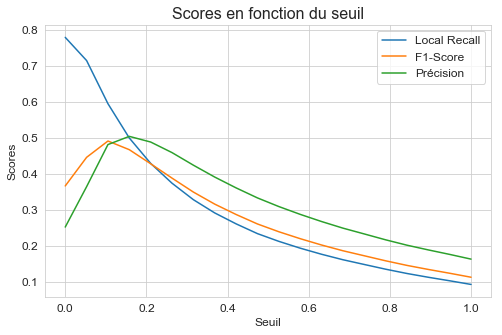

In [43]:
# Représentation des métriques (Naive Bayes)
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
plt.plot(thresh_list, local_recall_list, label="Local Recall")
plt.plot(thresh_list, f1_score_list, label="F1-Score")
plt.plot(thresh_list, accuracy_list, label="Précision")
ax.set_title("Scores en fonction du seuil", fontsize=16)
ax.set_xlabel("Seuil", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

In [44]:
print("F1-Score le plus élevé (NB) : {}".format(f1_score_list[np.argmax(f1_score_list)]))
print( "Treshold retenu : {}".format(thresh_list[np.argmax(f1_score_list)]))
print("Local Recall moyen associée : {}".format(local_recall_list[np.argmax(f1_score_list)]))
print("Précision associée : {}".format(accuracy_list[np.argmax(f1_score_list)]))

F1-Score le plus élevé (NB) : 0.4909440536567059
Treshold retenu : 0.10526315789473684
Local Recall moyen associée : 0.594639666160536
Précision associée : 0.48112082055095906


On utilise désormais le seuil que l'on vient de déterminer sur notre jeu de test.

In [45]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...")
test_predictions = []
count = 1
zero_array = np.zeros((X_test.shape[0]))
for classifier in classifiers:
    prediction = classifier.predict_proba(X_test)
    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    count += 1
print("Traitement terminé !")

Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...
Traitement terminé !


In [46]:
# On convertit en pd.dataframe
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=selected_tags)
# On utilise le threshold précedemment trouvé
trusted_threshold = thresh_list[np.argmax(f1_score_list)]
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

In [47]:
# Construction des tags prédites à partir de classifieurs,
# si il y en a plus de 5 nous conservons les 5 premiers avec la probabilité la plus forte
y_pred_ml = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)

# conversion en pd.dataframe
y_pred_ml = pd.DataFrame(y_pred_ml,columns=['Predicted_Tags'])

# On récupère les nouveaux tags dans une dataframe
y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])

# On construit un tableau pour comparer tags prédits et nouveaux tags
multilabel_comparison_df = pd.concat([y_test_new_tags, y_pred_ml], axis=1)

# On applique la fonction qui nous donne nombre de mots-clés justes parmi N mots-clés prédits
multilabel_comparison_df['Local_Recall'] = multilabel_comparison_df.apply(local_recall, axis=1)

# Affichages
display(multilabel_comparison_df.sample(20))
display(mean_local_recall(multilabel_comparison_df, unique_tags_serie))
display(other_scores(multilabel_comparison_df, unique_tags_serie))

,True_Tags,Predicted_Tags,Local_Recall
1394,html/css,html/javascript/css,1.0
1943,c++,c#,0.0
2914,c#/asp.net/javascript/silverlight/internet-exp...,c#/asp.net,0.4
2962,c,c++/c,1.0
1263,c#/entity-framework,c#/.net,0.5
4670,ruby-on-rails,mysql/ruby-on-rails/sql/sql-server,1.0
1345,design-patterns,c#,0.0
7124,unit-testing,.net/c#/java/asp.net,0.0
2594,c#/.net/asp.net/winforms,c#/.net/web-services,0.5
4419,javascript/performance,javascript,0.5


Recall moyen : 0.53


0.5255384090979502

F1 Score : 0.433
Précision : 0.428


(0.4333393832882537, 0.4283412351646989)

### Random Forest

In [48]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
rf_path = parent_path + '\\classifiers\\random_forest'

if os.path.exists(rf_path):
    shutil.rmtree(rf_path)
os.mkdir(rf_path)


classifiers = []
count=1
for category in selected_tags:
    print("{}/{} - Entrainement sur le Tag: '{}' ...".format(count, len(selected_tags),category))
# Sélection du classifieur
    clf = ensemble.RandomForestClassifier(n_estimators = 10) 
    clf= clf.fit(X_train, y_train[category])
    joblib.dump(clf, rf_path + "\\rf_"+category + ".pkl") # On sauvegarde notre encodage pour une utilisation ultérieure
    classifiers.append(clf)
    count=count+1


1/99 - Entrainement sur le Tag: 'c#' ...
2/99 - Entrainement sur le Tag: '.net' ...
3/99 - Entrainement sur le Tag: 'java' ...
4/99 - Entrainement sur le Tag: 'asp.net' ...
5/99 - Entrainement sur le Tag: 'javascript' ...
6/99 - Entrainement sur le Tag: 'c++' ...
7/99 - Entrainement sur le Tag: 'php' ...
8/99 - Entrainement sur le Tag: 'python' ...
9/99 - Entrainement sur le Tag: 'sql' ...
10/99 - Entrainement sur le Tag: 'sql-server' ...
11/99 - Entrainement sur le Tag: 'jquery' ...
12/99 - Entrainement sur le Tag: 'html' ...
13/99 - Entrainement sur le Tag: 'iphone' ...
14/99 - Entrainement sur le Tag: 'mysql' ...
15/99 - Entrainement sur le Tag: 'windows' ...
16/99 - Entrainement sur le Tag: 'asp.net-mvc' ...
17/99 - Entrainement sur le Tag: 'c' ...
18/99 - Entrainement sur le Tag: 'wpf' ...
19/99 - Entrainement sur le Tag: 'css' ...
20/99 - Entrainement sur le Tag: 'ruby-on-rails' ...
21/99 - Entrainement sur le Tag: 'visual-studio' ...
22/99 - Entrainement sur le Tag: 'database' .

In [49]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...")
test_predictions = []
count = 1
zero_array = np.zeros((X_test.shape[0]))
for classifier in classifiers:
    prediction = classifier.predict_proba(X_test)

    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    count += 1
print("Prédictions terminés !")

Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...
Prédictions terminés !


In [50]:
# On convertit en pd.dataframe
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test.columns)
# threshold
trusted_threshold = 0.02
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

In [51]:
# Construction des tags prédites à partir de classifieurs,
# si il y en a plus de 5 nous conservons les 5 premiers avec la probabilité la plus forte
y_pred_ml = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)

# Conversion en pd.dataframe
y_pred_ml = pd.DataFrame(y_pred_ml,columns=['Predicted_Tags'])

# On récupère les nouveaux tags dans une dataframe
y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])

# On construit un tableau pour comparer tags prédits et nouveaux tags
multilabel_comparison_df = pd.concat([y_test_new_tags, y_pred_ml], axis=1)

# On applique la fonction qui nous donne nombre de mots-clés justes parmi N mots-clés prédits
multilabel_comparison_df['Local_Recall'] = multilabel_comparison_df.apply(local_recall, axis=1)

# Affichages
display(multilabel_comparison_df.sample(20))
display(mean_local_recall(multilabel_comparison_df, unique_tags_serie))
display(other_scores(multilabel_comparison_df, unique_tags_serie))

,True_Tags,Predicted_Tags,Local_Recall
8571,c#/asp.net,c#/linq-to-sql/tsql/.net/sql,0.5
2645,perl,perl/linux/c++/php/bash,1.0
10714,xml,ruby-on-rails/c#,0.0
831,javascript,javascript/delphi,1.0
9814,asp.net/linq-to-sql,c#/asp.net/linq-to-sql/.net/linq,1.0
5198,cocoa-touch,iphone/cocoa/cocoa-touch/objective-c/c,1.0
8391,apache,apache/c#/php/linux/perl,1.0
7761,c#/.net,design-patterns/oop/vb.net/language-agnostic/c#,0.5
1217,javascript,javascript/html/svn/firefox/vb.net,1.0
5979,python,python/apache/visual-c++/windows/optimization,1.0


Recall moyen : 0.74


0.7350361005236934

F1 Score : 0.364
Précision : 0.256


(0.3637629834245991, 0.2562470949149392)

# Résultats et comparaison des 2 modèles

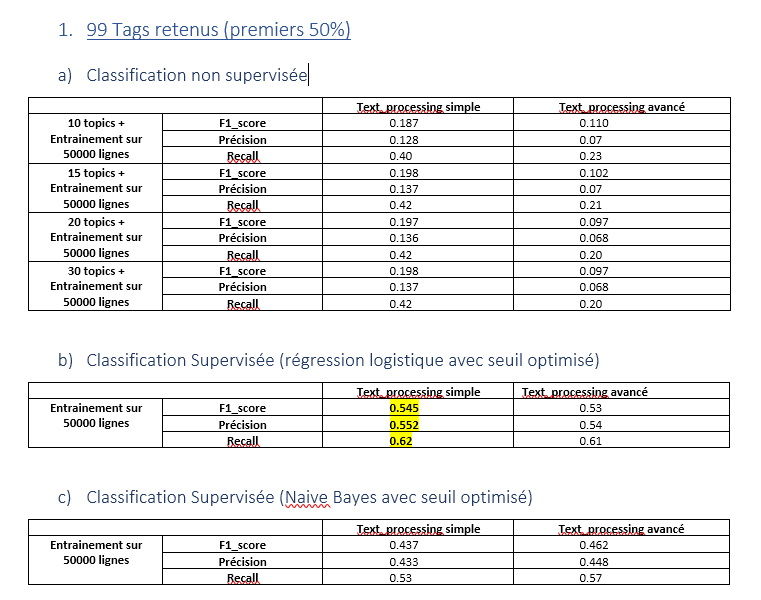

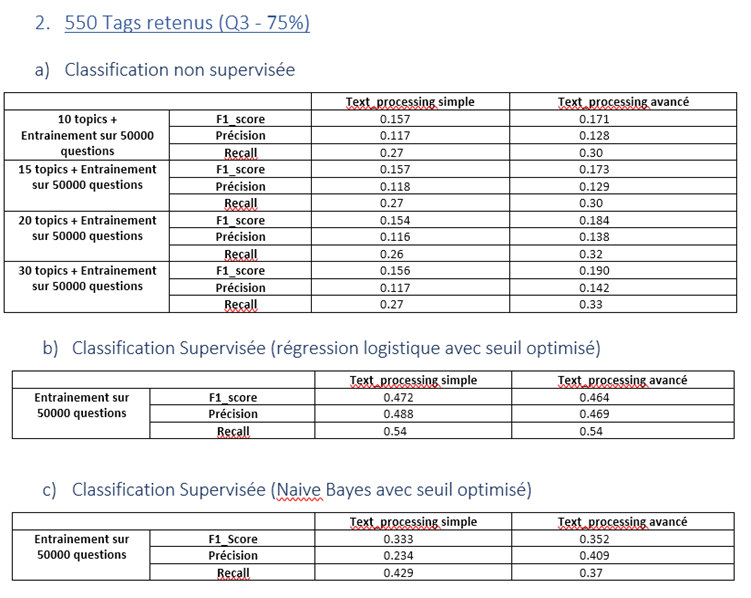

## Remarques

Le F1-Score est calculé comme suit à partir des précisions et rappels (recall)

 
•	A travers les résultats obtenus, nous pouvons privilégier la méthode supervisée de type régression logistique.

•	Clairement, la méthode non supervisée ne donne pas de bons résultats. Ainsi pour un recall élevé la précision sera assez faible, le F1-Score sera assez faible quel que soit le nombre de topic choisis. On remarque que cette méthode est plus sensible cependant au text processing avancé.

•	Il est à noter également que le text processing avancé ne produit pas nécessairement de meilleurs résultats. Cela montre que le TF-IDF est assez efficace pour retirer les mots qui ne sont pas importants.

•	On remarque aussi clairement que si on augmente le nombre de tags sélectionnés les résultats sont moins bons ce qui est assez logique car si le choix de tags diminue, l’algorithme a moins de chances de se « tromper ».  Retenir 99 tags (ceux qui représentent 50% des apparitions) est un bon compromis.

Nous avons maintenant les bons paramètres pour notre API.


# Conclusion


Le modèle choisi pour notre API est le modèle de régression logistique dans le cadre d’une classification supervisée. 

Nous avons tenté d’être le plus rigoureux possible sur la phase de nettoyage des données car celle-ci nécessite une attention particulière pour l’entrainement des données. Cependant cette tâche peut prendre un temps important et peut  donner l’impression d’être inutile voire tirer les résultats vers le bas au-delà d’un certain point. 

Il est à noter que faire appel à la transformation TF-IDF peut faciliter grandement la tâche et réduire le temps de traitement du texte en amont. 
